<a href="https://colab.research.google.com/github/decoderkurt/HUF_RL_2022/blob/main/28/6_RL_BTN_trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
%cd /

/


In [14]:
!git clone https://github.com/decoderkurt/RL-Bitcoin-trading-bot

fatal: destination path 'RL-Bitcoin-trading-bot' already exists and is not an empty directory.


In [15]:
%cd /RL-Bitcoin-trading-bot/RL-Bitcoin-trading-bot_6

/RL-Bitcoin-trading-bot/RL-Bitcoin-trading-bot_6


In [16]:
!pip install -r requirements.txt

In [17]:
%cd /RL-Bitcoin-trading-bot/RL-Bitcoin-trading-bot_6

/RL-Bitcoin-trading-bot/RL-Bitcoin-trading-bot_6


In [2]:
from google.colab.patches import cv2_imshow
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
from datetime import datetime
import os
import cv2
import numpy as np

def Write_to_file(Date, net_worth, filename='{}.txt'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))):
    for i in net_worth: 
        Date += " {}".format(i)
    #print(Date)
    if not os.path.exists('logs'):
        os.makedirs('logs')
    file = open("logs/"+filename, 'a+')
    file.write(Date+"\n")
    file.close()

class TradingGraph:
    # A crypto trading visualization using matplotlib made to render custom prices which come in following way:
    # Date, Open, High, Low, Close, Volume, net_worth, trades
    # call render every step
    def __init__(self, Render_range, Show_reward=False, Show_indicators=False):
        self.Volume = deque(maxlen=Render_range)
        self.net_worth = deque(maxlen=Render_range)
        self.render_data = deque(maxlen=Render_range)
        self.Render_range = Render_range
        self.Show_reward = Show_reward
        self.Show_indicators = Show_indicators

        # We are using the style ‘ggplot’
        plt.style.use('ggplot')
        # close all plots if there are open
        plt.close('all')
        # figsize attribute allows us to specify the width and height of a figure in unit inches
        self.fig = plt.figure(figsize=(16,8)) 

        # Create top subplot for price axis
        self.ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
        
        # Create bottom subplot for volume which shares its x-axis
        self.ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=self.ax1)
        
        # Create a new axis for net worth which shares its x-axis with price
        self.ax3 = self.ax1.twinx()

        # Formatting Date
        self.date_format = mpl_dates.DateFormatter('%d-%m-%Y')
        
        # Add paddings to make graph easier to view
        #plt.subplots_adjust(left=0.07, bottom=-0.1, right=0.93, top=0.97, wspace=0, hspace=0)

        # define if show indicators
        if self.Show_indicators:
            self.Create_indicators_lists()

    def Create_indicators_lists(self):
        # Create a new axis for indicatorswhich shares its x-axis with volume
        self.ax4 = self.ax2.twinx()
        
        self.sma7 = deque(maxlen=self.Render_range)
        self.sma25 = deque(maxlen=self.Render_range)
        self.sma99 = deque(maxlen=self.Render_range)
        
        self.bb_bbm = deque(maxlen=self.Render_range)
        self.bb_bbh = deque(maxlen=self.Render_range)
        self.bb_bbl = deque(maxlen=self.Render_range)
        
        self.psar = deque(maxlen=self.Render_range)

        self.MACD = deque(maxlen=self.Render_range)
        self.RSI = deque(maxlen=self.Render_range)


    def Plot_indicators(self, df, Date_Render_range):
        self.sma7.append(df["sma7"])
        self.sma25.append(df["sma25"])
        self.sma99.append(df["sma99"])

        self.bb_bbm.append(df["bb_bbm"])
        self.bb_bbh.append(df["bb_bbh"])
        self.bb_bbl.append(df["bb_bbl"])

        self.psar.append(df["psar"])

        self.MACD.append(df["MACD"])
        self.RSI.append(df["RSI"])

        # Add Simple Moving Average
        self.ax1.plot(Date_Render_range, self.sma7,'-')
        self.ax1.plot(Date_Render_range, self.sma25,'-')
        self.ax1.plot(Date_Render_range, self.sma99,'-')

        # Add Bollinger Bands
        self.ax1.plot(Date_Render_range, self.bb_bbm,'-')
        self.ax1.plot(Date_Render_range, self.bb_bbh,'-')
        self.ax1.plot(Date_Render_range, self.bb_bbl,'-')

        # Add Parabolic Stop and Reverse
        self.ax1.plot(Date_Render_range, self.psar,'.')

        self.ax4.clear()
        # # Add Moving Average Convergence Divergence
        self.ax4.plot(Date_Render_range, self.MACD,'r-')

        # # Add Relative Strength Index
        self.ax4.plot(Date_Render_range, self.RSI,'g-')

    # Render the environment to the screen
    #def render(self, Date, Open, High, Low, Close, Volume, net_worth, trades):
    def render(self, df, net_worth, trades):
        Date = df["Date"]
        Open = df["Open"]
        High = df["High"]
        Low = df["Low"]
        Close = df["Close"]
        Volume = df["Volume"]
        # append volume and net_worth to deque list
        self.Volume.append(Volume)
        self.net_worth.append(net_worth)

        # before appending to deque list, need to convert Date to special format
        Date = mpl_dates.date2num([pd.to_datetime(Date)])[0]
        self.render_data.append([Date, Open, High, Low, Close])
        
        # Clear the frame rendered last step
        self.ax1.clear()
        candlestick_ohlc(self.ax1, self.render_data, width=0.8/24, colorup='green', colordown='red', alpha=0.8)

        # Put all dates to one list and fill ax2 sublot with volume
        Date_Render_range = [i[0] for i in self.render_data]
        self.ax2.clear()
        self.ax2.fill_between(Date_Render_range, self.Volume, 0)

        if self.Show_indicators:
            self.Plot_indicators(df, Date_Render_range)

        # draw our net_worth graph on ax3 (shared with ax1) subplot
        self.ax3.clear()
        self.ax3.plot(Date_Render_range, self.net_worth, color="blue")
        
        # beautify the x-labels (Our Date format)
        self.ax1.xaxis.set_major_formatter(self.date_format)
        self.fig.autofmt_xdate()

        minimum = np.min(np.array(self.render_data)[:,1:])
        maximum = np.max(np.array(self.render_data)[:,1:])
        RANGE = maximum - minimum


        # sort sell and buy orders, put arrows in appropiate order positions
        for trade in trades:
            trade_date = mpl_dates.date2num([pd.to_datetime(trade['Date'])])[0]
            if trade_date in Date_Render_range:
                if trade['type'] == 'buy':
                    high_low = trade['Low'] - RANGE*0.02
                    ycoords = trade['Low'] - RANGE*0.08
                    self.ax1.scatter(trade_date, high_low, c='green', label='green', s = 120, edgecolors='none', marker="^")
                else:
                    high_low = trade['High'] + RANGE*0.02
                    ycoords = trade['High'] + RANGE*0.06
                    self.ax1.scatter(trade_date, high_low, c='red', label='red', s = 120, edgecolors='none', marker="v")

                if self.Show_reward:
                    try:
                        self.ax1.annotate('{0:.2f}'.format(trade['Reward']), (trade_date-0.02, high_low), xytext=(trade_date-0.02, ycoords),
                                                   bbox=dict(boxstyle='round', fc='w', ec='k', lw=1), fontsize="small")
                    except:
                        pass

        # we need to set layers every step, because we are clearing subplots every step
        self.ax2.set_xlabel('Date')
        self.ax1.set_ylabel('Price')
        self.ax3.set_ylabel('Balance')

        # I use tight_layout to replace plt.subplots_adjust
        self.fig.tight_layout()

        """Display image with matplotlib - interrupting other tasks"""
        # Show the graph without blocking the rest of the program
        #plt.show(block=False)
        # Necessary to view frames before they are unrendered
        #plt.pause(0.001)

        """Display image with OpenCV - no interruption"""

        # redraw the canvas
        self.fig.canvas.draw()
        # convert canvas to image
        img = np.fromstring(self.fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img  = img.reshape(self.fig.canvas.get_width_height()[::-1] + (3,))
        
        # img is rgb, convert to opencv's default bgr
        image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # display image with OpenCV or any operation you like
        cv2_imshow(image)

        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            return
        else:
            return img
        

def Plot_OHCL(df):
    df_original = df.copy()
    # necessary convert to datetime
    df["Date"] = pd.to_datetime(df.Date)
    df["Date"] = df["Date"].apply(mpl_dates.date2num)

    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    
    # We are using the style ‘ggplot’
    plt.style.use('ggplot')
    
    # figsize attribute allows us to specify the width and height of a figure in unit inches
    fig = plt.figure(figsize=(16,8)) 

    # Create top subplot for price axis
    ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)

    # Create bottom subplot for volume which shares its x-axis
    ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)

    candlestick_ohlc(ax1, df.values, width=0.8/24, colorup='green', colordown='red', alpha=0.8)
    ax1.set_ylabel('Price', fontsize=12)
    plt.xlabel('Date')
    plt.xticks(rotation=45)

    # Add Simple Moving Average
    ax1.plot(df["Date"], df_original['sma7'],'-')
    ax1.plot(df["Date"], df_original['sma25'],'-')
    ax1.plot(df["Date"], df_original['sma99'],'-')

    # Add Bollinger Bands
    ax1.plot(df["Date"], df_original['bb_bbm'],'-')
    ax1.plot(df["Date"], df_original['bb_bbh'],'-')
    ax1.plot(df["Date"], df_original['bb_bbl'],'-')

    # Add Parabolic Stop and Reverse
    ax1.plot(df["Date"], df_original['psar'],'.')

    # # Add Moving Average Convergence Divergence
    ax2.plot(df["Date"], df_original['MACD'],'-')

    # # Add Relative Strength Index
    ax2.plot(df["Date"], df_original['RSI'],'-')

    # beautify the x-labels (Our Date format)
    ax1.xaxis.set_major_formatter(mpl_dates.DateFormatter('%y-%m-%d'))# %H:%M:%S'))
    fig.autofmt_xdate()
    fig.tight_layout()
    
    plt.show()

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D#, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM as LSTM # only for GPU
from tensorflow.keras import backend as K
#tf.config.experimental_run_functions_eagerly(True) # used for debuging and development
tf.compat.v1.disable_eager_execution() # usually using this for fastest performance

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f'GPUs {gpus}')
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError: pass

class Shared_Model:
    def __init__(self, input_shape, action_space, lr, optimizer, model="Dense"):
        X_input = Input(input_shape)
        self.action_space = action_space

        # Shared CNN layers:
        if model=="CNN":
            X = Conv1D(filters=64, kernel_size=6, padding="same", activation="tanh")(X_input)
            X = MaxPooling1D(pool_size=2)(X)
            X = Conv1D(filters=32, kernel_size=3, padding="same", activation="tanh")(X)
            X = MaxPooling1D(pool_size=2)(X)
            X = Flatten()(X)

        # Shared LSTM layers:
        elif model=="LSTM":
            X = LSTM(512, return_sequences=True)(X_input)
            X = LSTM(256)(X)

        # Shared Dense layers:
        else:
            X = Flatten()(X_input)
            X = Dense(512, activation="relu")(X)
        
        # Critic model
        V = Dense(512, activation="relu")(X)
        V = Dense(256, activation="relu")(V)
        V = Dense(64, activation="relu")(V)
        value = Dense(1, activation=None)(V)

        self.Critic = Model(inputs=X_input, outputs = value)
        self.Critic.compile(loss=self.critic_PPO2_loss, optimizer=optimizer(lr=lr))

        # Actor model
        A = Dense(512, activation="relu")(X)
        A = Dense(256, activation="relu")(A)
        A = Dense(64, activation="relu")(A)
        output = Dense(self.action_space, activation="softmax")(A)

        self.Actor = Model(inputs = X_input, outputs = output)
        self.Actor.compile(loss=self.ppo_loss, optimizer=optimizer(lr=lr))
        #print(self.Actor.summary())

    def ppo_loss(self, y_true, y_pred):
        # Defined in https://arxiv.org/abs/1707.06347
        advantages, prediction_picks, actions = y_true[:, :1], y_true[:, 1:1+self.action_space], y_true[:, 1+self.action_space:]
        LOSS_CLIPPING = 0.2
        ENTROPY_LOSS = 0.001
        
        prob = actions * y_pred
        old_prob = actions * prediction_picks

        prob = K.clip(prob, 1e-10, 1.0)
        old_prob = K.clip(old_prob, 1e-10, 1.0)

        ratio = K.exp(K.log(prob) - K.log(old_prob))
        
        p1 = ratio * advantages
        p2 = K.clip(ratio, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages

        actor_loss = -K.mean(K.minimum(p1, p2))

        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy

        return total_loss

    def actor_predict(self, state):
        return self.Actor.predict(state)

    def critic_PPO2_loss(self, y_true, y_pred):
        value_loss = K.mean((y_true - y_pred) ** 2) # standard PPO loss
        return value_loss

    def critic_predict(self, state):
        return self.Critic.predict([state, np.zeros((state.shape[0], 1))])

        
class Actor_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        self.action_space = action_space

        X = Flatten(input_shape=input_shape)(X_input)
        X = Dense(512, activation="relu")(X)
        X = Dense(256, activation="relu")(X)
        X = Dense(64, activation="relu")(X)
        output = Dense(self.action_space, activation="softmax")(X)

        self.Actor = Model(inputs = X_input, outputs = output)
        self.Actor.compile(loss=self.ppo_loss, optimizer=optimizer(lr=lr))
        #print(self.Actor.summary)

    def ppo_loss(self, y_true, y_pred):
        # Defined in https://arxiv.org/abs/1707.06347
        advantages, prediction_picks, actions = y_true[:, :1], y_true[:, 1:1+self.action_space], y_true[:, 1+self.action_space:]
        LOSS_CLIPPING = 0.2
        ENTROPY_LOSS = 0.001
        
        prob = actions * y_pred
        old_prob = actions * prediction_picks

        prob = K.clip(prob, 1e-10, 1.0)
        old_prob = K.clip(old_prob, 1e-10, 1.0)

        ratio = K.exp(K.log(prob) - K.log(old_prob))
        
        p1 = ratio * advantages
        p2 = K.clip(ratio, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages

        actor_loss = -K.mean(K.minimum(p1, p2))

        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy

        return total_loss

    def actor_predict(self, state):
        return self.Actor.predict(state)

class Critic_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)

        V = Flatten(input_shape=input_shape)(X_input)
        V = Dense(512, activation="relu")(V)
        V = Dense(256, activation="relu")(V)
        V = Dense(64, activation="relu")(V)
        value = Dense(1, activation=None)(V)

        self.Critic = Model(inputs=X_input, outputs = value)
        self.Critic.compile(loss=self.critic_PPO2_loss, optimizer=optimizer(lr=lr))

    def critic_PPO2_loss(self, y_true, y_pred):
        value_loss = K.mean((y_true - y_pred) ** 2) # standard PPO loss
        return value_loss

    def critic_predict(self, state):
        return self.Critic.predict([state, np.zeros((state.shape[0], 1))])

In [4]:
import pandas as pd
from ta.trend import SMAIndicator, macd, PSARIndicator
from ta.volatility import BollingerBands
from ta.momentum import rsi


def AddIndicators(df):
    # Add Simple Moving Average (SMA) indicators
    df["sma7"] = SMAIndicator(close=df["Close"], window=7, fillna=True).sma_indicator()
    df["sma25"] = SMAIndicator(close=df["Close"], window=25, fillna=True).sma_indicator()
    df["sma99"] = SMAIndicator(close=df["Close"], window=99, fillna=True).sma_indicator()
    
    # Add Bollinger Bands indicator
    indicator_bb = BollingerBands(close=df["Close"], window=20, window_dev=2)
    df['bb_bbm'] = indicator_bb.bollinger_mavg()
    df['bb_bbh'] = indicator_bb.bollinger_hband()
    df['bb_bbl'] = indicator_bb.bollinger_lband()

    # Add Parabolic Stop and Reverse (Parabolic SAR) indicator
    indicator_psar = PSARIndicator(high=df["High"], low=df["Low"], close=df["Close"], step=0.02, max_step=2, fillna=True)
    df['psar'] = indicator_psar.psar()

    # Add Moving Average Convergence Divergence (MACD) indicator
    df["MACD"] = macd(close=df["Close"], window_slow=26, window_fast=12, fillna=True) # mazas

    # Add Relative Strength Index (RSI) indicator
    df["RSI"] = rsi(close=df["Close"], window=14, fillna=True) # mazas
    
    return df


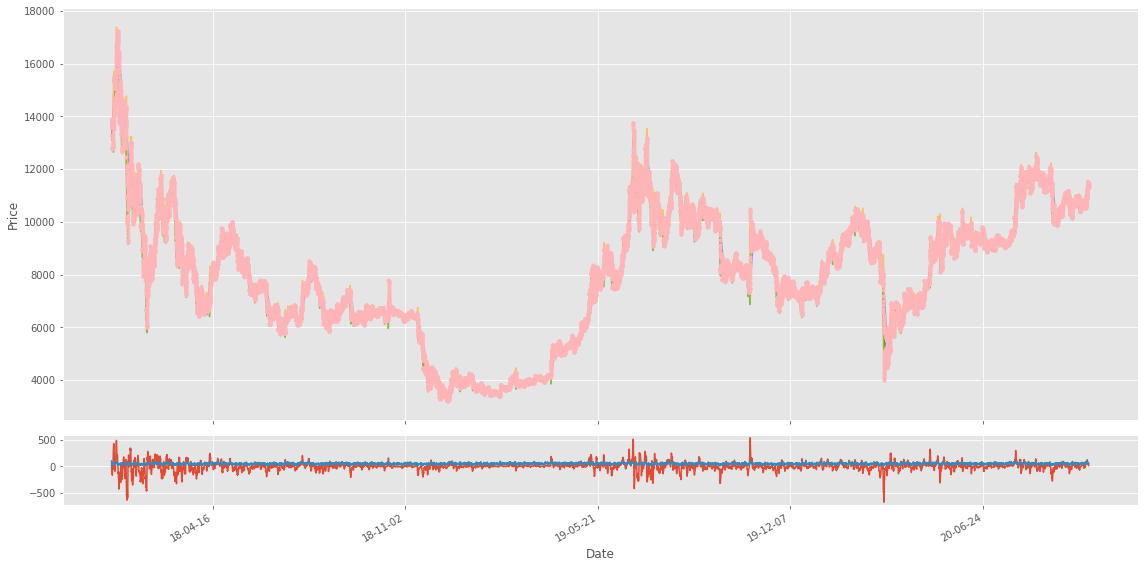

In [6]:
df = pd.read_csv('./BTCUSD_1h.csv')
df = df.sort_values('Date')
df = AddIndicators(df)

test_df = df[-400:]

Plot_OHCL(df)

In [7]:
from collections import deque
from multiprocessing import Process, Pipe
import numpy as np
from datetime import datetime

class Environment(Process):
    def __init__(self, env_idx, child_conn, env, training_batch_size, visualize):
        super(Environment, self).__init__()
        self.env = env
        self.env_idx = env_idx
        self.child_conn = child_conn
        self.training_batch_size = training_batch_size
        self.visualize = visualize

    def run(self):
        super(Environment, self).run()
        state = self.env.reset(env_steps_size = self.training_batch_size)
        self.child_conn.send(state)
        while True:
            reset, net_worth, episode_orders = 0, 0, 0
            action = self.child_conn.recv()
            if self.env_idx == 0:
                self.env.render(self.visualize)
            state, reward, done = self.env.step(action)

            if done or self.env.current_step == self.env.end_step:
                net_worth = self.env.net_worth
                episode_orders = self.env.episode_orders
                state = self.env.reset(env_steps_size = self.training_batch_size)
                reset = 1

            self.child_conn.send([state, reward, done, reset, net_worth, episode_orders])

def train_multiprocessing(CustomEnv, agent, train_df, num_worker=4, training_batch_size=500, visualize=False, EPISODES=10000):
    works, parent_conns, child_conns = [], [], []
    episode = 0
    total_average = deque(maxlen=100) # save recent 100 episodes net worth
    best_average = 0 # used to track best average net worth

    for idx in range(num_worker):
        parent_conn, child_conn = Pipe()
        env = CustomEnv(train_df, lookback_window_size=agent.lookback_window_size)
        work = Environment(idx, child_conn, env, training_batch_size, visualize)
        work.start()
        works.append(work)
        parent_conns.append(parent_conn)
        child_conns.append(child_conn)

    agent.create_writer(env.initial_balance, env.normalize_value, EPISODES) # create TensorBoard writer

    states =        [[] for _ in range(num_worker)]
    next_states =   [[] for _ in range(num_worker)]
    actions =       [[] for _ in range(num_worker)]
    rewards =       [[] for _ in range(num_worker)]
    dones =         [[] for _ in range(num_worker)]
    predictions =   [[] for _ in range(num_worker)]

    state = [0 for _ in range(num_worker)]
    for worker_id, parent_conn in enumerate(parent_conns):
        state[worker_id] = parent_conn.recv()

    while episode < EPISODES:
        predictions_list = agent.Actor.actor_predict(np.reshape(state, [num_worker]+[_ for _ in state[0].shape]))
        actions_list = [np.random.choice(agent.action_space, p=i) for i in predictions_list]

        for worker_id, parent_conn in enumerate(parent_conns):
            parent_conn.send(actions_list[worker_id])
            action_onehot = np.zeros(agent.action_space.shape[0])
            action_onehot[actions_list[worker_id]] = 1
            actions[worker_id].append(action_onehot)
            predictions[worker_id].append(predictions_list[worker_id])

        for worker_id, parent_conn in enumerate(parent_conns):
            next_state, reward, done, reset, net_worth, episode_orders = parent_conn.recv()
            states[worker_id].append(np.expand_dims(state[worker_id], axis=0))
            next_states[worker_id].append(np.expand_dims(next_state, axis=0))
            rewards[worker_id].append(reward)
            dones[worker_id].append(done)
            state[worker_id] = next_state

            if reset:
                episode += 1
                a_loss, c_loss = agent.replay(states[worker_id], actions[worker_id], rewards[worker_id], predictions[worker_id], dones[worker_id], next_states[worker_id])
                total_average.append(net_worth)
                average = np.average(total_average)

                agent.writer.add_scalar('Data/average net_worth', average, episode)
                agent.writer.add_scalar('Data/episode_orders', episode_orders, episode)
                
                print("episode: {:<5} worker: {:<1} net worth: {:<7.2f} average: {:<7.2f} orders: {}".format(episode, worker_id, net_worth, average, episode_orders))
                if episode > len(total_average):
                    if best_average < average:
                        best_average = average
                        print("Saving model")
                        agent.save(score="{:.2f}".format(best_average), args=[episode, average, episode_orders, a_loss, c_loss])
                    agent.save()
                
                states[worker_id] = []
                next_states[worker_id] = []
                actions[worker_id] = []
                rewards[worker_id] = []
                dones[worker_id] = []
                predictions[worker_id] = []

    agent.end_training_log()
    # terminating processes after while loop
    works.append(work)
    for work in works:
        work.terminate()
        print('TERMINATED:', work)
        work.join()

def test_multiprocessing(CustomEnv, agent, test_df, num_worker = 4, visualize=False, test_episodes=1000, folder="", name="Crypto_trader", comment="", initial_balance=1000):
    agent.load(folder, name)
    works, parent_conns, child_conns = [], [], []
    average_net_worth = 0
    average_orders = 0
    no_profit_episodes = 0
    episode = 0

    for idx in range(num_worker):
        parent_conn, child_conn = Pipe()
        env = CustomEnv(test_df, initial_balance=initial_balance, lookback_window_size=agent.lookback_window_size)
        work = Environment(idx, child_conn, env, training_batch_size=0, visualize=visualize)
        work.start()
        works.append(work)
        parent_conns.append(parent_conn)
        child_conns.append(child_conn)

    state = [0 for _ in range(num_worker)]
    for worker_id, parent_conn in enumerate(parent_conns):
        state[worker_id] = parent_conn.recv()

    while episode < test_episodes:
        predictions_list = agent.Actor.actor_predict(np.reshape(state, [num_worker]+[_ for _ in state[0].shape]))
        actions_list = [np.random.choice(agent.action_space, p=i) for i in predictions_list]

        for worker_id, parent_conn in enumerate(parent_conns):
            parent_conn.send(actions_list[worker_id])

        for worker_id, parent_conn in enumerate(parent_conns):
            next_state, reward, done, reset, net_worth, episode_orders = parent_conn.recv()
            state[worker_id] = next_state

            if reset:
                episode += 1
                #print(episode, net_worth, episode_orders)
                average_net_worth += net_worth
                average_orders += episode_orders
                if net_worth < initial_balance: no_profit_episodes += 1 # calculate episode count where we had negative profit through episode
                print("episode: {:<5} worker: {:<1} net worth: {:<7.2f} average_net_worth: {:<7.2f} orders: {}".format(episode, worker_id, net_worth, average_net_worth/episode, episode_orders))
                if episode == test_episodes: break
            
    print("No profit episodes: {}".format(no_profit_episodes))
    # save test results to test_results.txt file
    with open("test_results.txt", "a+") as results:
        current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
        results.write(f'{current_date}, {name}, test episodes:{test_episodes}')
        results.write(f', net worth:{average_net_worth/(episode+1)}, orders per episode:{average_orders/test_episodes}')
        results.write(f', no profit episodes:{no_profit_episodes}, comment: {comment}\n')
    
    # terminating processes after while loop
    works.append(work)
    for work in works:
        work.terminate()
        print('TERMINATED:', work)
        work.join()

In [8]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import copy
import pandas as pd
import numpy as np
import random
from collections import deque
from tensorboardX import SummaryWriter
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
from datetime import datetime

class CustomAgent:
    # A custom Bitcoin trading agent
    def __init__(self, lookback_window_size=50, lr=0.00005, epochs=1, optimizer=Adam, batch_size=32, model=""):
        self.lookback_window_size = lookback_window_size
        self.model = model
        
        # Action space from 0 to 3, 0 is hold, 1 is buy, 2 is sell
        self.action_space = np.array([0, 1, 2])

        # folder to save models
        self.log_name = datetime.now().strftime("%Y_%m_%d_%H_%M")+"_Crypto_trader"
        
        # State size contains Market+Orders history for the last lookback_window_size steps
        #self.state_size = (lookback_window_size, 10)
        self.state_size = (lookback_window_size, 10+9) # 10 standard information +9 indicators

        # Neural Networks part bellow
        self.lr = lr
        self.epochs = epochs
        self.optimizer = optimizer
        self.batch_size = batch_size

        # Create shared Actor-Critic network model
        self.Actor = self.Critic = Shared_Model(input_shape=self.state_size, action_space = self.action_space.shape[0], lr=self.lr, optimizer = self.optimizer, model=self.model)
        # Create Actor-Critic network model
        #self.Actor = Actor_Model(input_shape=self.state_size, action_space = self.action_space.shape[0], lr=self.lr, optimizer = self.optimizer)
        #self.Critic = Critic_Model(input_shape=self.state_size, action_space = self.action_space.shape[0], lr=self.lr, optimizer = self.optimizer)
        
    # create tensorboard writer
    def create_writer(self, initial_balance, normalize_value, train_episodes):
        self.replay_count = 0
        self.writer = SummaryWriter('runs/'+self.log_name)

        # Create folder to save models
        if not os.path.exists(self.log_name):
            os.makedirs(self.log_name)

        self.start_training_log(initial_balance, normalize_value, train_episodes)
            
    def start_training_log(self, initial_balance, normalize_value, train_episodes):      
        # save training parameters to Parameters.txt file for future
        with open(self.log_name+"/Parameters.txt", "w") as params:
            current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
            params.write(f"training start: {current_date}\n")
            params.write(f"initial_balance: {initial_balance}\n")
            params.write(f"training episodes: {train_episodes}\n")
            params.write(f"lookback_window_size: {self.lookback_window_size}\n")
            params.write(f"lr: {self.lr}\n")
            params.write(f"epochs: {self.epochs}\n")
            params.write(f"batch size: {self.batch_size}\n")
            params.write(f"normalize_value: {normalize_value}\n")
            params.write(f"model: {self.model}\n")
            
    def end_training_log(self):
        with open(self.log_name+"/Parameters.txt", "a+") as params:
            current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
            params.write(f"training end: {current_date}\n")

    def get_gaes(self, rewards, dones, values, next_values, gamma = 0.99, lamda = 0.95, normalize=True):
        deltas = [r + gamma * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        deltas = np.stack(deltas)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(deltas) - 1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * gamma * lamda * gaes[t + 1]

        target = gaes + values
        if normalize:
            gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return np.vstack(gaes), np.vstack(target)

    def replay(self, states, actions, rewards, predictions, dones, next_states):
        # reshape memory to appropriate shape for training
        states = np.vstack(states)
        next_states = np.vstack(next_states)
        actions = np.vstack(actions)
        predictions = np.vstack(predictions)

        # Get Critic network predictions 
        values = self.Critic.critic_predict(states)
        next_values = self.Critic.critic_predict(next_states)
        
        # Compute advantages
        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))
        '''
        plt.plot(target,'-')
        plt.plot(advantages,'.')
        ax=plt.gca()
        ax.grid(True)
        plt.show()
        '''
        # stack everything to numpy array
        y_true = np.hstack([advantages, predictions, actions])
        
        # training Actor and Critic networks
        a_loss = self.Actor.Actor.fit(states, y_true, epochs=self.epochs, verbose=0, shuffle=True, batch_size=self.batch_size)
        c_loss = self.Critic.Critic.fit(states, target, epochs=self.epochs, verbose=0, shuffle=True, batch_size=self.batch_size)

        self.writer.add_scalar('Data/actor_loss_per_replay', np.sum(a_loss.history['loss']), self.replay_count)
        self.writer.add_scalar('Data/critic_loss_per_replay', np.sum(c_loss.history['loss']), self.replay_count)
        self.replay_count += 1

        return np.sum(a_loss.history['loss']), np.sum(c_loss.history['loss'])

    def act(self, state):
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.actor_predict(np.expand_dims(state, axis=0))[0]
        action = np.random.choice(self.action_space, p=prediction)
        return action, prediction
        
    def save(self, name="Crypto_trader", score="", args=[]):
        # save keras model weights
        self.Actor.Actor.save_weights(f"{self.log_name}/{score}_{name}_Actor.h5")
        self.Critic.Critic.save_weights(f"{self.log_name}/{score}_{name}_Critic.h5")

        # log saved model arguments to file
        if len(args) > 0:
            with open(f"{self.log_name}/log.txt", "a+") as log:
                current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                atgumets = ""
                for arg in args:
                    atgumets += f", {arg}"
                log.write(f"{current_time}{atgumets}\n")

    def load(self, folder, name):
        # load keras model weights
        self.Actor.Actor.load_weights(os.path.join(folder, f"{name}_Actor.h5"))
        self.Critic.Critic.load_weights(os.path.join(folder, f"{name}_Critic.h5"))

        
class CustomEnv:
    # A custom Bitcoin trading environment
    def __init__(self, df, initial_balance=1000, lookback_window_size=50, Render_range=100, Show_reward=False, Show_indicators=False, normalize_value=40000):
        # Define action space and state size and other custom parameters
        self.df = df.dropna().reset_index()
        self.df_total_steps = len(self.df)-1
        self.initial_balance = initial_balance
        self.lookback_window_size = lookback_window_size
        self.Render_range = Render_range # render range in visualization
        self.Show_reward = Show_reward # show order reward in rendered visualization
        self.Show_indicators = Show_indicators # show main indicators in rendered visualization

        # Orders history contains the balance, net_worth, crypto_bought, crypto_sold, crypto_held values for the last lookback_window_size steps
        self.orders_history = deque(maxlen=self.lookback_window_size)
        
        # Market history contains the OHCL values for the last lookback_window_size prices
        self.market_history = deque(maxlen=self.lookback_window_size)

        self.indicators_history = deque(maxlen=self.lookback_window_size)

        self.normalize_value = normalize_value

    # Reset the state of the environment to an initial state
    def reset(self, env_steps_size = 0):
        self.visualization = TradingGraph(Render_range=self.Render_range, Show_reward=self.Show_reward, Show_indicators=self.Show_indicators) # init visualization
        self.trades = deque(maxlen=self.Render_range) # limited orders memory for visualization
        
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.crypto_held = 0
        self.crypto_sold = 0
        self.crypto_bought = 0
        self.episode_orders = 0 # track episode orders count
        self.prev_episode_orders = 0 # track previous episode orders count
        self.rewards = deque(maxlen=self.Render_range)
        self.env_steps_size = env_steps_size
        self.punish_value = 0
        if env_steps_size > 0: # used for training dataset
            self.start_step = random.randint(self.lookback_window_size, self.df_total_steps - env_steps_size)
            self.end_step = self.start_step + env_steps_size
        else: # used for testing dataset
            self.start_step = self.lookback_window_size
            self.end_step = self.df_total_steps
            
        self.current_step = self.start_step

        for i in reversed(range(self.lookback_window_size)):
            current_step = self.current_step - i
            self.orders_history.append([self.balance, self.net_worth, self.crypto_bought, self.crypto_sold, self.crypto_held])

            self.market_history.append([self.df.loc[current_step, 'Open'],
                                        self.df.loc[current_step, 'High'],
                                        self.df.loc[current_step, 'Low'],
                                        self.df.loc[current_step, 'Close'],
                                        self.df.loc[current_step, 'Volume'],
                                        ])

            self.indicators_history.append(
                [self.df.loc[current_step, 'sma7'] / self.normalize_value,
                                        self.df.loc[current_step, 'sma25'] / self.normalize_value,
                                        self.df.loc[current_step, 'sma99'] / self.normalize_value,
                                        self.df.loc[current_step, 'bb_bbm'] / self.normalize_value,
                                        self.df.loc[current_step, 'bb_bbh'] / self.normalize_value,
                                        self.df.loc[current_step, 'bb_bbl'] / self.normalize_value,
                                        self.df.loc[current_step, 'psar'] / self.normalize_value,
                                        self.df.loc[current_step, 'MACD'] / 400,
                                        self.df.loc[current_step, 'RSI'] / 100
                                        ])
            

        state = np.concatenate((self.market_history, self.orders_history), axis=1) / self.normalize_value
        state = np.concatenate((state, self.indicators_history), axis=1)

        return state

    # Get the data points for the given current_step
    def _next_observation(self):
        self.market_history.append([self.df.loc[self.current_step, 'Open'],
                                    self.df.loc[self.current_step, 'High'],
                                    self.df.loc[self.current_step, 'Low'],
                                    self.df.loc[self.current_step, 'Close'],
                                    self.df.loc[self.current_step, 'Volume'],
                                    ])

        self.indicators_history.append([self.df.loc[self.current_step, 'sma7'] / self.normalize_value,
                                    self.df.loc[self.current_step, 'sma25'] / self.normalize_value,
                                    self.df.loc[self.current_step, 'sma99'] / self.normalize_value,
                                    self.df.loc[self.current_step, 'bb_bbm'] / self.normalize_value,
                                    self.df.loc[self.current_step, 'bb_bbh'] / self.normalize_value,
                                    self.df.loc[self.current_step, 'bb_bbl'] / self.normalize_value,
                                    self.df.loc[self.current_step, 'psar'] / self.normalize_value,
                                    self.df.loc[self.current_step, 'MACD'] / 400,
                                    self.df.loc[self.current_step, 'RSI'] / 100
                                    ])
        
        obs = np.concatenate((self.market_history, self.orders_history), axis=1) / self.normalize_value
        obs = np.concatenate((obs, self.indicators_history), axis=1)
        
        return obs

    # Execute one time step within the environment
    def step(self, action):
        self.crypto_bought = 0
        self.crypto_sold = 0
        self.current_step += 1

        # Set the current price to a random price between open and close
        #current_price = random.uniform(
        #    self.df.loc[self.current_step, 'Open'],
        #    self.df.loc[self.current_step, 'Close'])
        current_price = self.df.loc[self.current_step, 'Open']
        Date = self.df.loc[self.current_step, 'Date'] # for visualization
        High = self.df.loc[self.current_step, 'High'] # for visualization
        Low = self.df.loc[self.current_step, 'Low'] # for visualization

        if action == 0: # Hold
            pass

        elif action == 1 and self.balance > self.initial_balance/100:
            # Buy with 100% of current balance
            self.crypto_bought = self.balance / current_price
            self.balance -= self.crypto_bought * current_price
            self.crypto_held += self.crypto_bought
            self.trades.append({'Date' : Date, 'High' : High, 'Low' : Low, 'total': self.crypto_bought, 'type': "buy", 'current_price': current_price})
            self.episode_orders += 1

        elif action == 2 and self.crypto_held>0:
            # Sell 100% of current crypto held
            self.crypto_sold = self.crypto_held
            self.balance += self.crypto_sold * current_price
            self.crypto_held -= self.crypto_sold
            self.trades.append({'Date' : Date, 'High' : High, 'Low' : Low, 'total': self.crypto_sold, 'type': "sell", 'current_price': current_price})
            self.episode_orders += 1

        self.prev_net_worth = self.net_worth
        self.net_worth = self.balance + self.crypto_held * current_price

        self.orders_history.append([self.balance, self.net_worth, self.crypto_bought, self.crypto_sold, self.crypto_held])

        # Receive calculated reward
        reward = self.get_reward()

        if self.net_worth <= self.initial_balance/2:
            done = True
        else:
            done = False

        obs = self._next_observation()
        
        return obs, reward, done

    # Calculate reward
    def get_reward(self):
        self.punish_value += self.net_worth * 0.00001
        if self.episode_orders > 1 and self.episode_orders > self.prev_episode_orders:
            self.prev_episode_orders = self.episode_orders
            if self.trades[-1]['type'] == "buy" and self.trades[-2]['type'] == "sell":
                reward = self.trades[-2]['total']*self.trades[-2]['current_price'] - self.trades[-2]['total']*self.trades[-1]['current_price']
                reward -= self.punish_value
                self.punish_value = 0
                self.trades[-1]["Reward"] = reward
                return reward
            elif self.trades[-1]['type'] == "sell" and self.trades[-2]['type'] == "buy":
                reward = self.trades[-1]['total']*self.trades[-1]['current_price'] - self.trades[-2]['total']*self.trades[-2]['current_price']
                reward -= self.punish_value
                self.punish_value = 0
                self.trades[-1]["Reward"] = reward
                return reward
        else:
            return 0 - self.punish_value

    # render environment
    def render(self, visualize = False):
        #print(f'Step: {self.current_step}, Net Worth: {self.net_worth}')
        if visualize:
            # Render the environment to the screen
            img = self.visualization.render(self.df.loc[self.current_step], self.net_worth, self.trades)
            return img

        
def Random_games(env, visualize, test_episodes = 50, comment=""):
    average_net_worth = 0
    average_orders = 0
    no_profit_episodes = 0
    for episode in range(test_episodes):
        state = env.reset()
        while True:
            env.render(visualize)
            action = np.random.randint(3, size=1)[0]
            state, reward, done = env.step(action)
            if env.current_step == env.end_step:
                average_net_worth += env.net_worth
                average_orders += env.episode_orders
                if env.net_worth < env.initial_balance: no_profit_episodes += 1 # calculate episode count where we had negative profit through episode
                print("episode: {}, net_worth: {}, average_net_worth: {}, orders: {}".format(episode, env.net_worth, average_net_worth/(episode+1), env.episode_orders))
                break

    print("average {} episodes random net_worth: {}, orders: {}".format(test_episodes, average_net_worth/test_episodes, average_orders/test_episodes))
    # save test results to test_results.txt file
    with open("test_results.txt", "a+") as results:
        current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
        results.write(f'{current_date}, {"Random games"}, test episodes:{test_episodes}')
        results.write(f', net worth:{average_net_worth/(episode+1)}, orders per episode:{average_orders/test_episodes}')
        results.write(f', no profit episodes:{no_profit_episodes}, comment: {comment}\n')

def train_agent(env, agent, visualize=False, train_episodes = 50, training_batch_size=500):
    agent.create_writer(env.initial_balance, env.normalize_value, train_episodes) # create TensorBoard writer
    total_average = deque(maxlen=100) # save recent 100 episodes net worth
    best_average = 0 # used to track best average net worth
    for episode in range(train_episodes):
        state = env.reset(env_steps_size = training_batch_size)

        states, actions, rewards, predictions, dones, next_states = [], [], [], [], [], []
        for t in range(training_batch_size):
            env.render(visualize)
            action, prediction = agent.act(state)
            next_state, reward, done = env.step(action)
            states.append(np.expand_dims(state, axis=0))
            next_states.append(np.expand_dims(next_state, axis=0))
            action_onehot = np.zeros(3)
            action_onehot[action] = 1
            actions.append(action_onehot)
            rewards.append(reward)
            dones.append(done)
            predictions.append(prediction)
            state = next_state

        a_loss, c_loss = agent.replay(states, actions, rewards, predictions, dones, next_states)
        total_average.append(env.net_worth)
        average = np.average(total_average)
        
        agent.writer.add_scalar('Data/average net_worth', average, episode)
        agent.writer.add_scalar('Data/episode_orders', env.episode_orders, episode)
        
        print("episode: {:<5} net worth {:<7.2f} average: {:<7.2f} orders: {}".format(episode, env.net_worth, average, env.episode_orders))
        if episode > len(total_average):
            if best_average < average:
                best_average = average
                print("Saving model")
                agent.save(score="{:.2f}".format(best_average), args=[episode, average, env.episode_orders, a_loss, c_loss])
            agent.save()
            
    agent.end_training_log()
    

def test_agent(env, agent, visualize=True, test_episodes=10, folder="", name="Crypto_trader", comment=""):
    agent.load(folder, name)
    average_net_worth = 0
    average_orders = 0
    no_profit_episodes = 0
    for episode in range(test_episodes):
        state = env.reset()
        while True:
            env.render(visualize)
            action, prediction = agent.act(state)
            state, reward, done = env.step(action)
            if env.current_step == env.end_step:
                average_net_worth += env.net_worth
                average_orders += env.episode_orders
                if env.net_worth < env.initial_balance: no_profit_episodes += 1 # calculate episode count where we had negative profit through episode
                print("episode: {:<5}, net_worth: {:<7.2f}, average_net_worth: {:<7.2f}, orders: {}".format(episode, env.net_worth, average_net_worth/(episode+1), env.episode_orders))
                break
            
    print("average {} episodes agent net_worth: {}, orders: {}".format(test_episodes, average_net_worth/test_episodes, average_orders/test_episodes))
    print("No profit episodes: {}".format(no_profit_episodes))
    # save test results to test_results.txt file
    with open("test_results.txt", "a+") as results:
        current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
        results.write(f'{current_date}, {name}, test episodes:{test_episodes}')
        results.write(f', net worth:{average_net_worth/(episode+1)}, orders per episode:{average_orders/test_episodes}')
        results.write(f', no profit episodes:{no_profit_episodes}, model: {agent.model}, comment: {comment}\n')


In [ ]:
df = pd.read_csv('./BTCUSD_1h.csv')
df = df.sort_values('Date')
df = AddIndicators(df) # insert indicators to df

lookback_window_size = 50
test_window = 720*3 # 3 months 
train_df = df[100:-test_window-lookback_window_size] # we leave 100 to have properly calculated indicators
test_df = df[-test_window-lookback_window_size:]

# single processing training
#agent = CustomAgent(lookback_window_size=lookback_window_size, lr=0.00001, epochs=5, optimizer=Adam, batch_size = 32, model="Dense")
#train_env = CustomEnv(train_df, lookback_window_size=lookback_window_size)
#train_agent(train_env, agent, visualize=False, train_episodes=50000, training_batch_size=500)

# multiprocessing training/testing. Note - run from cmd or terminal
agent = CustomAgent(lookback_window_size=lookback_window_size, lr=0.00001, epochs=5, optimizer=Adam, batch_size = 32, model="Dense")
#train_multiprocessing(CustomEnv, agent, train_df, num_worker = 32, training_batch_size=500, visualize=False, EPISODES=200000)
test_multiprocessing(CustomEnv, agent, test_df, num_worker = 4, visualize=False, test_episodes=1000, folder="2021_01_21_20_06_Crypto_trader", name="1984.93_Crypto_trader", comment="Dense")

# Downloder

In [11]:
import bitfinex
import datetime
import time
import pandas as pd

# Define query parameters
pair = 'BTCUSD' # Currency pair of interest
TIMEFRAME = '1h'#,'4h','1h','15m','1m'
TIMEFRAME_S = 3600 # seconds in TIMEFRAME

# Define the start date
t_start = datetime.datetime(2018, 1, 1, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000

# Define the end date
t_stop = datetime.datetime(2022, 1, 26, 0, 0)
t_stop = time.mktime(t_stop.timetuple()) * 1000

def fetch_data(start, stop, symbol, interval, TIMEFRAME_S):
    limit = 1000    # We want the maximum of 1000 data points
    # Create api instance
    api_v2 = bitfinex.bitfinex_v2.api_v2()
    hour = TIMEFRAME_S * 1000
    step = hour * limit
    data = []

    total_steps = (stop-start)/hour
    while total_steps > 0:
        if total_steps < limit: # recalculating ending steps
            step = total_steps * hour

        end = start + step
        data += api_v2.candles(symbol=symbol, interval=interval, limit=limit, start=start, end=end)
        print(pd.to_datetime(start, unit='ms'), pd.to_datetime(end, unit='ms'), "steps left:", total_steps)
        start = start + step
        total_steps -= limit
        time.sleep(1.5)
    return data

result = fetch_data(t_start, t_stop, pair, TIMEFRAME, TIMEFRAME_S)
names = ['Date', 'Open', 'Close', 'High', 'Low', 'Volume']
df = pd.DataFrame(result, columns=names)
df.drop_duplicates(inplace=True)
df['Date'] = pd.to_datetime(df['Date'], unit='ms')
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df.to_csv(f"{pair}_{TIMEFRAME}.csv")


No keys, only access to public API functions
2018-01-01 00:00:00 2018-02-11 16:00:00 steps left: 35664.0
2018-02-11 16:00:00 2018-03-25 08:00:00 steps left: 34664.0
2018-03-25 08:00:00 2018-05-06 00:00:00 steps left: 33664.0
2018-05-06 00:00:00 2018-06-16 16:00:00 steps left: 32664.0
2018-06-16 16:00:00 2018-07-28 08:00:00 steps left: 31664.0
2018-07-28 08:00:00 2018-09-08 00:00:00 steps left: 30664.0
2018-09-08 00:00:00 2018-10-19 16:00:00 steps left: 29664.0
2018-10-19 16:00:00 2018-11-30 08:00:00 steps left: 28664.0
2018-11-30 08:00:00 2019-01-11 00:00:00 steps left: 27664.0
2019-01-11 00:00:00 2019-02-21 16:00:00 steps left: 26664.0
2019-02-21 16:00:00 2019-04-04 08:00:00 steps left: 25664.0
2019-04-04 08:00:00 2019-05-16 00:00:00 steps left: 24664.0
2019-05-16 00:00:00 2019-06-26 16:00:00 steps left: 23664.0
2019-06-26 16:00:00 2019-08-07 08:00:00 steps left: 22664.0
2019-08-07 08:00:00 2019-09-18 00:00:00 steps left: 21664.0
2019-09-18 00:00:00 2019-10-29 16:00:00 steps left: 206

No keys, only access to public API functions


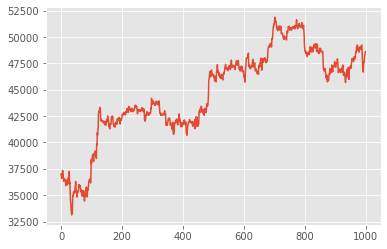

In [12]:
import bitfinex
import datetime
import time
import pandas as pd

# Create api instance of the v2 API
api_v2 = bitfinex.bitfinex_v2.api_v2()

# Define query parameters
pair = 'BTCUSD' # Currency pair of interest
TIMEFRAME = '1h'#,'4h','1h','15m','1m'

# Define the start date
t_start = datetime.datetime(2018, 9, 1, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000

# Define the end date
t_stop = datetime.datetime(2022, 1, 26, 0, 0)
t_stop = time.mktime(t_stop.timetuple()) * 1000

# Download OHCL data from API
result = api_v2.candles(symbol=pair, interval=TIMEFRAME, limit=1000, start=t_start, end=t_stop)

# Convert list of data to pandas dataframe
names = ['Date', 'Open', 'Close', 'High', 'Low', 'Volume']
df = pd.DataFrame(result, columns=names)
df['Date'] = pd.to_datetime(df['Date'], unit='ms')

# we can plot our downloaded data
import matplotlib.pyplot as plt
plt.plot(df['Open'],'-')
plt.show()